https://y-t-g.github.io/tutorials/yolov8n-add-classes/ 사이트를 참고하여 작성하였습니다.

In [1]:
! pip install -q Roboflow

데이터세트 다운로드

In [2]:

from roboflow import Roboflow
rf = Roboflow(api_key="2DwijB6WhwEgy0Wjk0ON")
project = rf.workspace("project-n3wam").project("project-ttd5y")
version = project.version(1)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Project-1 in yolov8:: 100%|██████████| 2012/2012 [00:00<00:00, 14515.48it/s]


데이터세트 위치 설정

In [ ]:
! mkdir -p /content/datasets/Project-1
! mv Project-1/** /content/datasets/Project-1
# ! mv /content/datasets/Project-1/data.yaml /content/datasets

In [4]:
# ! git clone https://github.com/ultralytics/ultralytics
# ! cd ultralytics

# # The patch may break for later versions. Change to the one used when writing this.
# ! git reset --hard 6806f15396432fffb951250d650454b840eb4c28

# # Install this ultralytics repo as an editable Python package
# ! pip install -e .
# ! wget https://gist.githubusercontent.com/Y-T-G/8f4fc0b78a0a559a06fe84ae4f359e6e/raw/f8e9ba1644cbfa86295f14fbe26c3d91a504b155/add_head.patch
# ! git apply add_head.patch

In [5]:
from ultralytics import YOLO
import torch
import copy


# Initialize pretrained model
model = YOLO("yolov8n.pt")

# Keep a copy of old state dict for sanity check
old_dict = copy.deepcopy(model.state_dict())

# We should freeze all but the last layer
model.state_dict().keys()

odict_keys(['model.model.0.conv.weight', 'model.model.0.bn.weight', 'model.model.0.bn.bias', 'model.model.0.bn.running_mean', 'model.model.0.bn.running_var', 'model.model.0.bn.num_batches_tracked', 'model.model.1.conv.weight', 'model.model.1.bn.weight', 'model.model.1.bn.bias', 'model.model.1.bn.running_mean', 'model.model.1.bn.running_var', 'model.model.1.bn.num_batches_tracked', 'model.model.2.cv1.conv.weight', 'model.model.2.cv1.bn.weight', 'model.model.2.cv1.bn.bias', 'model.model.2.cv1.bn.running_mean', 'model.model.2.cv1.bn.running_var', 'model.model.2.cv1.bn.num_batches_tracked', 'model.model.2.cv2.conv.weight', 'model.model.2.cv2.bn.weight', 'model.model.2.cv2.bn.bias', 'model.model.2.cv2.bn.running_mean', 'model.model.2.cv2.bn.running_var', 'model.model.2.cv2.bn.num_batches_tracked', 'model.model.2.m.0.cv1.conv.weight', 'model.model.2.m.0.cv1.bn.weight', 'model.model.2.m.0.cv1.bn.bias', 'model.model.2.m.0.cv1.bn.running_mean', 'model.model.2.m.0.cv1.bn.running_var', 'model.mod

In [6]:
# Add a callback to put the frozen layers in eval mode to prevent BN values
# from changing.

def put_in_eval_mode(trainer, n_layers=22):
  for i, (name, module) in enumerate(trainer.model.named_modules()):
    if name.endswith("bn") and int(name.split('.')[1]) < n_layers:
      module.eval()
      module.track_running_stats = False
      # print(name, " put in eval mode.")

model.add_callback("on_train_epoch_start", put_in_eval_mode)

# Also add it during model setup because of a bug that changes the BN values even before the training starts.
model.add_callback("on_pretrain_routine_start", put_in_eval_mode)

모델 구조 변경없이 단순히 freeze 파라미터만 사용하여 학습

2개 클래스 탐지

```yaml
names:
  - d_license_plate
  - pl_license_plate
nc: 2
```

In [7]:
# Train the model. Freeze the first 22 layers [0-21].
# Original 문서는 '/content/datasets/data.yaml' 사용하였으나, 최신 Roboflow에서 구조가 바뀐 듯 함.
results = model.train(data='/content/datasets/Project-1/data.yaml', freeze=22, epochs=100, imgsz=640)

New https://pypi.org/project/ultralytics/8.3.30 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.28 🚀 Python-3.10.15 torch-2.3.1 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 15974MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/datasets/Project-1/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=22, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None

train: Scanning /content/datasets/Project-1/train/labels.cache... 700 images, 0 backgrounds, 0 corrupt: 100%|██████████| 700/700 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 1.4.21 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
val: Scanning /content/datasets/Project-1/valid/labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to /ultralytics/runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /ultralytics/runs/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.06G     0.9338      2.708      1.239         29        640: 100%|██████████| 44/44 [00:02<00:00, 16.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]

                   all        200        218      0.597      0.146      0.292      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.782G     0.8638      2.051      1.182         31        640: 100%|██████████| 44/44 [00:01<00:00, 27.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.62it/s]


                   all        200        218      0.535      0.526      0.441      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.782G     0.8737      1.834      1.181         22        640: 100%|██████████| 44/44 [00:01<00:00, 28.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 12.87it/s]

                   all        200        218       0.51       0.65      0.583      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.782G     0.8725      1.734      1.174         27        640: 100%|██████████| 44/44 [00:01<00:00, 28.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 13.96it/s]


                   all        200        218       0.63      0.655      0.716      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.782G     0.8382      1.615      1.152         38        640: 100%|██████████| 44/44 [00:01<00:00, 29.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.61it/s]

                   all        200        218      0.593      0.742      0.726      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.782G     0.8123       1.46      1.133         26        640: 100%|██████████| 44/44 [00:01<00:00, 31.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.82it/s]

                   all        200        218      0.669      0.746      0.766      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.782G     0.7932      1.383      1.127         30        640: 100%|██████████| 44/44 [00:01<00:00, 31.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.23it/s]

                   all        200        218       0.67      0.774      0.788      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.782G     0.7835      1.317      1.123         26        640: 100%|██████████| 44/44 [00:01<00:00, 32.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.77it/s]

                   all        200        218      0.753        0.7      0.794      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.782G     0.7796      1.255      1.115         23        640: 100%|██████████| 44/44 [00:01<00:00, 32.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.64it/s]

                   all        200        218      0.685      0.722      0.758      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.782G     0.7692       1.24      1.105         25        640: 100%|██████████| 44/44 [00:01<00:00, 31.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.87it/s]

                   all        200        218      0.639      0.725      0.758      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      0.78G     0.7577      1.193      1.107         30        640: 100%|██████████| 44/44 [00:01<00:00, 31.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.55it/s]

                   all        200        218      0.645      0.787      0.775      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      0.78G     0.7622      1.177      1.094         22        640: 100%|██████████| 44/44 [00:01<00:00, 30.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.50it/s]

                   all        200        218      0.723      0.772      0.825      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.782G     0.7554      1.123      1.106         13        640: 100%|██████████| 44/44 [00:01<00:00, 31.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.04it/s]

                   all        200        218      0.745      0.821      0.859       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      0.78G     0.7441      1.121      1.089         21        640: 100%|██████████| 44/44 [00:01<00:00, 30.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.19it/s]

                   all        200        218      0.714       0.83      0.841      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      0.78G     0.7526      1.111      1.097         26        640: 100%|██████████| 44/44 [00:01<00:00, 32.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.72it/s]

                   all        200        218      0.741      0.801      0.844      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      0.78G     0.7339      1.084      1.081         21        640: 100%|██████████| 44/44 [00:01<00:00, 31.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.88it/s]

                   all        200        218      0.798      0.807      0.866      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      0.78G     0.7288      1.065      1.079         24        640: 100%|██████████| 44/44 [00:01<00:00, 31.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.28it/s]

                   all        200        218      0.729      0.784      0.815      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      0.78G     0.7231       1.03      1.085         20        640: 100%|██████████| 44/44 [00:01<00:00, 30.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.36it/s]

                   all        200        218      0.781      0.755      0.846      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      0.78G     0.7339      1.029      1.084         35        640: 100%|██████████| 44/44 [00:01<00:00, 31.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.13it/s]

                   all        200        218      0.743      0.836      0.869      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      0.78G     0.7025     0.9912      1.078         24        640: 100%|██████████| 44/44 [00:01<00:00, 32.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.32it/s]

                   all        200        218      0.726      0.895      0.873      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      0.78G     0.7137     0.9687      1.067         25        640: 100%|██████████| 44/44 [00:01<00:00, 30.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.83it/s]

                   all        200        218      0.811      0.839      0.887      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      0.78G      0.709     0.9881      1.071         29        640: 100%|██████████| 44/44 [00:01<00:00, 32.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.02it/s]

                   all        200        218      0.773       0.76       0.88      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      0.78G     0.7036     0.9896      1.075         30        640: 100%|██████████| 44/44 [00:01<00:00, 30.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.96it/s]

                   all        200        218      0.689      0.887      0.866      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.782G     0.7181     0.9704      1.081         28        640: 100%|██████████| 44/44 [00:01<00:00, 30.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.83it/s]

                   all        200        218      0.855      0.798      0.896      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      0.78G     0.6938     0.9679      1.066         23        640: 100%|██████████| 44/44 [00:01<00:00, 33.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.08it/s]

                   all        200        218      0.803      0.814      0.884      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      0.78G     0.6823     0.9554      1.053         30        640: 100%|██████████| 44/44 [00:01<00:00, 32.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.75it/s]

                   all        200        218      0.787      0.874      0.885      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      0.78G     0.6962     0.9309      1.062         21        640: 100%|██████████| 44/44 [00:01<00:00, 32.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.37it/s]

                   all        200        218      0.801      0.797      0.889      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      0.78G     0.7002     0.9488      1.058         24        640: 100%|██████████| 44/44 [00:01<00:00, 33.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.34it/s]

                   all        200        218      0.738      0.852      0.878      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      0.78G     0.6939     0.9472       1.07         25        640: 100%|██████████| 44/44 [00:01<00:00, 31.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.31it/s]

                   all        200        218      0.769      0.817      0.858       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      0.78G     0.6968     0.9442      1.062         29        640: 100%|██████████| 44/44 [00:01<00:00, 32.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.58it/s]

                   all        200        218      0.862      0.772       0.88      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      0.78G     0.6745     0.9169      1.056         29        640: 100%|██████████| 44/44 [00:01<00:00, 31.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.06it/s]

                   all        200        218       0.83      0.795      0.883      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      0.78G     0.6763      0.896      1.059         25        640: 100%|██████████| 44/44 [00:01<00:00, 32.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.17it/s]

                   all        200        218       0.77      0.833      0.893      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      0.78G     0.6739     0.9239      1.056         26        640: 100%|██████████| 44/44 [00:01<00:00, 32.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.61it/s]

                   all        200        218      0.774      0.866      0.893      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      0.78G      0.678     0.9142      1.063         19        640: 100%|██████████| 44/44 [00:01<00:00, 31.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.35it/s]

                   all        200        218      0.815      0.871      0.887      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      0.78G     0.6815     0.8949      1.046         25        640: 100%|██████████| 44/44 [00:01<00:00, 32.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.45it/s]

                   all        200        218      0.834      0.792      0.904      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      0.78G     0.6733     0.9003      1.059         25        640: 100%|██████████| 44/44 [00:01<00:00, 31.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.54it/s]

                   all        200        218      0.772      0.857      0.894       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      0.78G     0.6621     0.8928      1.046         22        640: 100%|██████████| 44/44 [00:01<00:00, 29.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.25it/s]

                   all        200        218      0.794      0.829      0.872      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      0.78G     0.6548     0.8757      1.051         22        640: 100%|██████████| 44/44 [00:01<00:00, 31.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.06it/s]

                   all        200        218      0.815      0.816      0.902      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      0.78G     0.6714     0.8709      1.051         24        640: 100%|██████████| 44/44 [00:01<00:00, 30.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.63it/s]

                   all        200        218      0.775      0.855      0.888      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      0.78G     0.6712     0.8766      1.056         38        640: 100%|██████████| 44/44 [00:01<00:00, 33.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.89it/s]

                   all        200        218      0.845      0.811      0.904      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      0.78G     0.6586     0.8658      1.049         38        640: 100%|██████████| 44/44 [00:01<00:00, 32.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.36it/s]

                   all        200        218      0.774       0.88      0.888      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      0.78G     0.6232     0.8451      1.035         29        640: 100%|██████████| 44/44 [00:01<00:00, 31.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.36it/s]

                   all        200        218      0.821      0.817      0.906      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      0.78G     0.6517      0.882      1.047         27        640: 100%|██████████| 44/44 [00:01<00:00, 31.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.68it/s]

                   all        200        218       0.83      0.863      0.913      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      0.78G      0.666     0.8638      1.042         29        640: 100%|██████████| 44/44 [00:01<00:00, 31.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.29it/s]

                   all        200        218      0.768      0.885      0.911      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      0.78G     0.6436     0.8446      1.035         19        640: 100%|██████████| 44/44 [00:01<00:00, 31.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.76it/s]

                   all        200        218      0.861      0.838      0.917      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      0.78G     0.6445     0.8521      1.046         19        640: 100%|██████████| 44/44 [00:01<00:00, 31.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.38it/s]

                   all        200        218       0.79      0.818      0.899      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      0.78G     0.6657     0.8595      1.052         17        640: 100%|██████████| 44/44 [00:01<00:00, 32.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.09it/s]

                   all        200        218      0.842      0.819       0.91       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      0.78G     0.6495     0.8287      1.034         26        640: 100%|██████████| 44/44 [00:01<00:00, 30.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.46it/s]

                   all        200        218      0.837      0.873      0.919      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      0.78G     0.6385     0.8324      1.043         24        640: 100%|██████████| 44/44 [00:01<00:00, 32.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.55it/s]

                   all        200        218      0.801       0.85      0.906       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      0.78G     0.6406     0.8269      1.045         27        640: 100%|██████████| 44/44 [00:01<00:00, 29.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.63it/s]

                   all        200        218      0.852      0.844      0.921      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      0.78G     0.6445     0.8288      1.039         28        640: 100%|██████████| 44/44 [00:01<00:00, 31.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.36it/s]

                   all        200        218      0.809      0.815      0.885      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      0.78G     0.6358     0.8376      1.035         20        640: 100%|██████████| 44/44 [00:01<00:00, 32.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.53it/s]

                   all        200        218      0.828      0.805      0.896      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      0.78G     0.6438     0.8178      1.029         28        640: 100%|██████████| 44/44 [00:01<00:00, 31.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.31it/s]

                   all        200        218       0.85      0.811       0.92      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      0.78G     0.6451     0.8198      1.041         23        640: 100%|██████████| 44/44 [00:01<00:00, 32.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.90it/s]

                   all        200        218      0.838      0.822      0.919      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      0.78G     0.6302      0.806      1.031         23        640: 100%|██████████| 44/44 [00:01<00:00, 32.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.92it/s]

                   all        200        218      0.865      0.821      0.919      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      0.78G     0.6397     0.8172       1.03         27        640: 100%|██████████| 44/44 [00:01<00:00, 32.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.75it/s]

                   all        200        218      0.866      0.837      0.917      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      0.78G     0.6315     0.8029      1.036         21        640: 100%|██████████| 44/44 [00:01<00:00, 31.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.44it/s]

                   all        200        218      0.796      0.887      0.923      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      0.78G     0.6352     0.7985      1.041         17        640: 100%|██████████| 44/44 [00:01<00:00, 30.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.03it/s]

                   all        200        218      0.861       0.81       0.92      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      0.78G     0.6173     0.7874      1.016         25        640: 100%|██████████| 44/44 [00:01<00:00, 32.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.51it/s]

                   all        200        218       0.84      0.843      0.916      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      0.78G     0.6501      0.815      1.045         22        640: 100%|██████████| 44/44 [00:01<00:00, 32.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.53it/s]

                   all        200        218      0.868      0.817      0.914       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      0.78G     0.6379     0.7962      1.042         29        640: 100%|██████████| 44/44 [00:01<00:00, 31.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 20.16it/s]

                   all        200        218      0.811      0.825      0.903      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      0.78G     0.6263     0.7871      1.024         30        640: 100%|██████████| 44/44 [00:01<00:00, 32.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.39it/s]

                   all        200        218      0.827      0.883      0.916      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      0.78G     0.6307     0.7985      1.032         24        640: 100%|██████████| 44/44 [00:01<00:00, 32.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.92it/s]

                   all        200        218       0.85      0.892      0.932      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      0.78G     0.6271      0.796      1.029         27        640: 100%|██████████| 44/44 [00:01<00:00, 32.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.83it/s]

                   all        200        218      0.841       0.89      0.929      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      0.78G     0.6194     0.7953      1.027         25        640: 100%|██████████| 44/44 [00:01<00:00, 31.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.80it/s]

                   all        200        218      0.829      0.845      0.913      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      0.78G     0.6127     0.7924      1.025         24        640: 100%|██████████| 44/44 [00:01<00:00, 32.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.75it/s]

                   all        200        218      0.856      0.881      0.928      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      0.78G     0.6185     0.7758      1.022         27        640: 100%|██████████| 44/44 [00:01<00:00, 30.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.64it/s]

                   all        200        218      0.837      0.868      0.928      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      0.78G     0.6132     0.7984       1.03         22        640: 100%|██████████| 44/44 [00:01<00:00, 31.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.67it/s]

                   all        200        218      0.805      0.897      0.929      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      0.78G     0.6114     0.7778      1.018         20        640: 100%|██████████| 44/44 [00:01<00:00, 31.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.74it/s]

                   all        200        218      0.811      0.904      0.926      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      0.78G     0.6196     0.7842      1.032         24        640: 100%|██████████| 44/44 [00:01<00:00, 32.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.21it/s]

                   all        200        218      0.813      0.893       0.94      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      0.78G     0.6048     0.7545      1.018         20        640: 100%|██████████| 44/44 [00:01<00:00, 31.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.42it/s]

                   all        200        218      0.858       0.89      0.941       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      0.78G     0.6063     0.7522      1.024         29        640: 100%|██████████| 44/44 [00:01<00:00, 31.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.19it/s]

                   all        200        218      0.858      0.875      0.934      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      0.78G     0.5981     0.7744      1.025         27        640: 100%|██████████| 44/44 [00:01<00:00, 30.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.53it/s]

                   all        200        218      0.856      0.839      0.927      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      0.78G     0.6221     0.7835       1.04         15        640: 100%|██████████| 44/44 [00:01<00:00, 31.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.44it/s]

                   all        200        218      0.854      0.881       0.93       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      0.78G     0.5929      0.755       1.01         29        640: 100%|██████████| 44/44 [00:01<00:00, 30.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.00it/s]

                   all        200        218      0.826        0.9      0.926      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      0.78G     0.6065     0.7624       1.02         43        640: 100%|██████████| 44/44 [00:01<00:00, 32.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.70it/s]

                   all        200        218      0.886      0.877      0.933      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      0.78G     0.5974     0.7565      1.023         32        640: 100%|██████████| 44/44 [00:01<00:00, 33.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.97it/s]

                   all        200        218      0.809      0.881      0.927      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      0.78G     0.6005     0.7632      1.029         20        640: 100%|██████████| 44/44 [00:01<00:00, 32.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.59it/s]

                   all        200        218      0.821      0.877      0.929      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      0.78G     0.5888     0.7568      1.022         23        640: 100%|██████████| 44/44 [00:01<00:00, 31.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.04it/s]

                   all        200        218      0.827      0.894      0.937      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      0.78G     0.5968     0.7448       1.03         21        640: 100%|██████████| 44/44 [00:01<00:00, 30.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.19it/s]

                   all        200        218      0.815       0.87      0.928      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      0.78G     0.5971      0.759      1.022         25        640: 100%|██████████| 44/44 [00:01<00:00, 31.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.39it/s]

                   all        200        218      0.886       0.85      0.937      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      0.78G     0.5767     0.7574      1.005         21        640: 100%|██████████| 44/44 [00:01<00:00, 31.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 16.82it/s]

                   all        200        218       0.87      0.857      0.943       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      0.78G     0.5866     0.7311      1.017         31        640: 100%|██████████| 44/44 [00:01<00:00, 30.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.18it/s]

                   all        200        218      0.869      0.872      0.939      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      0.78G     0.5895     0.7354      1.006         24        640: 100%|██████████| 44/44 [00:01<00:00, 32.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.34it/s]

                   all        200        218      0.857      0.903      0.939      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      0.78G     0.5725     0.7379      1.016         21        640: 100%|██████████| 44/44 [00:01<00:00, 31.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.55it/s]

                   all        200        218      0.866      0.906       0.94      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      0.78G     0.5883      0.738      1.015         23        640: 100%|██████████| 44/44 [00:01<00:00, 32.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.60it/s]

                   all        200        218      0.859      0.859      0.931      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      0.78G     0.5898     0.7416      1.015         27        640: 100%|██████████| 44/44 [00:01<00:00, 31.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.52it/s]

                   all        200        218      0.882       0.87      0.941      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      0.78G     0.5934     0.7257      1.015         35        640: 100%|██████████| 44/44 [00:01<00:00, 31.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.77it/s]

                   all        200        218      0.817      0.922      0.935      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      0.78G     0.5737     0.7434      1.013         29        640: 100%|██████████| 44/44 [00:01<00:00, 30.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 17.94it/s]

                   all        200        218      0.867      0.888       0.94      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      0.78G     0.5681     0.7493      1.015         28        640: 100%|██████████| 44/44 [00:01<00:00, 31.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.64it/s]

                   all        200        218      0.844       0.89      0.939      0.748


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      1.05G     0.5865     0.5985      1.042         12        640: 100%|██████████| 44/44 [00:01<00:00, 26.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.49it/s]

                   all        200        218      0.825      0.897       0.93      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100     0.782G     0.5646     0.6009      1.043         12        640: 100%|██████████| 44/44 [00:01<00:00, 33.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.03it/s]

                   all        200        218      0.893      0.861      0.935      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100     0.782G     0.5744     0.6068       1.03         12        640: 100%|██████████| 44/44 [00:01<00:00, 33.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.02it/s]

                   all        200        218      0.878      0.864      0.933      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100     0.782G     0.5848     0.5945      1.035         12        640: 100%|██████████| 44/44 [00:01<00:00, 34.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.81it/s]

                   all        200        218      0.847      0.886      0.939      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100     0.782G     0.5638     0.5862      1.045         12        640: 100%|██████████| 44/44 [00:01<00:00, 34.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.17it/s]

                   all        200        218      0.851      0.915      0.941       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100     0.782G     0.5674     0.5866      1.033         18        640: 100%|██████████| 44/44 [00:01<00:00, 32.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 20.25it/s]

                   all        200        218      0.816      0.922      0.938      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100     0.782G     0.5732     0.5794      1.048         12        640: 100%|██████████| 44/44 [00:01<00:00, 34.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.67it/s]

                   all        200        218      0.802      0.918      0.937      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100     0.782G     0.5592     0.5951      1.041         12        640: 100%|██████████| 44/44 [00:01<00:00, 34.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.97it/s]

                   all        200        218      0.827      0.913      0.939      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100     0.782G     0.5618     0.5732       1.02         12        640: 100%|██████████| 44/44 [00:01<00:00, 33.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 19.27it/s]

                   all        200        218      0.836      0.906      0.942       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100     0.782G     0.5535     0.5709      1.029         12        640: 100%|██████████| 44/44 [00:01<00:00, 33.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 18.55it/s]

                   all        200        218      0.859      0.892      0.943      0.758



100 epochs completed in 0.061 hours.
Optimizer stripped from /ultralytics/runs/detect/train2/weights/last.pt, 6.3MB
Optimizer stripped from /ultralytics/runs/detect/train2/weights/best.pt, 6.3MB

Validating /ultralytics/runs/detect/train2/weights/best.pt...
Ultralytics 8.3.28 🚀 Python-3.10.15 torch-2.3.1 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 15974MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.68it/s]


                   all        200        218      0.851      0.915      0.941       0.76
       d_license_plate        107        107      0.848      0.938      0.933       0.76
      pl_license_plate         93        111      0.854      0.892      0.949       0.76
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /ultralytics/runs/detect/train2


freeze 작동 확인

In [8]:
def compare_dicts(state_dict1, state_dict2):
    # Compare the keys
    keys1 = set(state_dict1.keys())
    keys2 = set(state_dict2.keys())

    if keys1 != keys2:
        print("Models have different parameter names.")
        return False

    # Compare the values (weights)
    for key in keys1:
        if not torch.equal(state_dict1[key], state_dict2[key]):
            print(f"Weights for parameter '{key}' are different.")
            if "bn" in key and "22" not in key:
              state_dict1[key] = state_dict2[key]

# Compare the dicts. Changes should only be in layer 22 and above
compare_dicts(old_dict, model.state_dict())

Weights for parameter 'model.model.22.cv3.0.1.bn.bias' are different.
Weights for parameter 'model.model.22.cv2.0.1.bn.running_mean' are different.
Weights for parameter 'model.model.22.cv3.0.0.bn.running_mean' are different.
Weights for parameter 'model.model.22.cv3.1.0.bn.running_var' are different.
Weights for parameter 'model.model.22.cv3.0.1.conv.weight' are different.
Weights for parameter 'model.model.22.cv2.1.2.bias' are different.
Weights for parameter 'model.model.22.cv3.1.0.bn.weight' are different.
Weights for parameter 'model.model.22.cv2.0.0.bn.running_var' are different.
Weights for parameter 'model.model.22.cv3.1.1.bn.bias' are different.
Weights for parameter 'model.model.22.cv3.0.1.bn.running_mean' are different.
Weights for parameter 'model.model.22.cv3.1.2.weight' are different.
Weights for parameter 'model.model.22.cv2.1.0.bn.running_mean' are different.
Weights for parameter 'model.model.22.cv2.2.1.bn.weight' are different.
Weights for parameter 'model.model.22.cv

학습한 가중치를 저장하기 이전에 모델의 Head를 먼저 변경

Detect를 수행하는 22번 레이어를 23번으로 인덱스만 변경

In [9]:
new_state_dict = dict()

#  Increment the head number by 1 in the state_dict
for k, v in model.state_dict().items():
  if k.startswith("model.model.22"):
    new_state_dict[k.replace("model.22", "model.23")] = v

# Save the current state_dict. Only layer 23.
torch.save(new_state_dict, "yolov8n_lp.pth")

COCO Pretrained 모델(0~22)의 가중치를 Concat 모델(0~23)에 불러옴

- layer.22 는 COCO의 가중치
- layer.23 은 새로운 클래스의 가중치
- 22, 23 을 ConcatHead에서 병합

In [10]:
model_2 = YOLO('ultralytics/cfg/models/v8/yolov8n-2xhead.yaml', task="detect").load('yolov8n.pt')

Transferred 355/440 items from pretrained weights


가중치가 비어있는 23번 레이어를 새로운 클래스의 가중치로 초기화

In [11]:
state_dict = torch.load("yolov8n_lp.pth")

# Load state_dict of the custom trained model head. Layer 23.
model_2.load_state_dict(state_dict, strict=False)

_IncompatibleKeys(missing_keys=['model.model.0.conv.weight', 'model.model.0.bn.weight', 'model.model.0.bn.bias', 'model.model.0.bn.running_mean', 'model.model.0.bn.running_var', 'model.model.1.conv.weight', 'model.model.1.bn.weight', 'model.model.1.bn.bias', 'model.model.1.bn.running_mean', 'model.model.1.bn.running_var', 'model.model.2.cv1.conv.weight', 'model.model.2.cv1.bn.weight', 'model.model.2.cv1.bn.bias', 'model.model.2.cv1.bn.running_mean', 'model.model.2.cv1.bn.running_var', 'model.model.2.cv2.conv.weight', 'model.model.2.cv2.bn.weight', 'model.model.2.cv2.bn.bias', 'model.model.2.cv2.bn.running_mean', 'model.model.2.cv2.bn.running_var', 'model.model.2.m.0.cv1.conv.weight', 'model.model.2.m.0.cv1.bn.weight', 'model.model.2.m.0.cv1.bn.bias', 'model.model.2.m.0.cv1.bn.running_mean', 'model.model.2.m.0.cv1.bn.running_var', 'model.model.2.m.0.cv2.conv.weight', 'model.model.2.m.0.cv2.bn.weight', 'model.model.2.m.0.cv2.bn.bias', 'model.model.2.m.0.cv2.bn.running_mean', 'model.model

최종 모델 저장


image 1/1 /ultralytics/test_demo.jpg: 416x640 1 0, 6 2s, 2 80s, 196.1ms
Speed: 2.2ms preprocess, 196.1ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)
Results saved to /ultralytics/runs/detect/predict2


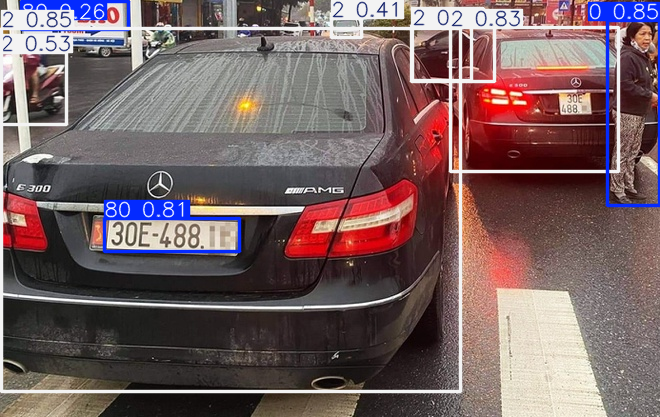

In [12]:
results = model_2.predict("test_demo.jpg", save=True)
results[0].show()